# Classic ML Algorithms: SVM & Naïve Bayes


## Import necessary libraries

In [209]:
# Basic data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For data preprocessing and cleaning
import emoji 
from emoji import demojize, emojize

# Sklearn related
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion # Add FeatureUnion to the list
from sklearn.model_selection import train_test_split # We don't need this one for now
#from sklearn.feature_union import FeatureUnion # Add FeatureUnion to the list
from sklearn.base  import BaseEstimator, TransformerMixin # Add BaseEstimator, TransformerMixin to the list
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report 

# NLP Libraries
import nltk
import spacy
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords # I dont want to use this one for now
from nltk.tokenize import word_tokenize
from spacy.lang.en import English

# For saving and loading models
import joblib

#or timing the Code
import time

In [210]:
# load spacy model
nlp = spacy.load('en_core_web_sm')

In [211]:

vectorizer = CountVectorizer

## Load the data

The three datasets are split before and can be imported directly

In [212]:
# Read the data from the tsv file
train_df = pd.read_csv('/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/train.tsv', sep='\t')
dev_df = pd.read_csv('/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/dev.tsv', sep='\t')
test_df = pd.read_csv('/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/test.tsv', sep = '\t') 


Prepare features and labels for each set

In [213]:
X_train = train_df.iloc[:, 0] # The first column is the tweets
y_train = train_df.iloc[:, 1] # The second column is the labels

# Follow the same steps for the dev set
X_dev = dev_df.iloc[:, 0]
y_dev = dev_df.iloc[:, 1]

# Follow the same steps for the test set
X_test = test_df.iloc[:, 0]
y_test = test_df.iloc[:, 1]

# Map the labels to integers
label_map = {'OFF': 1, 'NOT': 0}
y_train = y_train.map(label_map)
y_dev = y_dev.map(label_map)
y_test = y_test.map(label_map)

# Save the labels fro classification report
class_names = ['Offensive', 'Not Offensive']

## Data cleaning and preprocessing

### Create a custom transformer for text cleaning

In [214]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): # This transformer doesn't need to learn anything about the data
        return self
    
    def transform(self, X): # This transformer returns the cleaned text
        cleaned_text = [] # Create an empty list to store the cleaned text
        for text in X:
            # convert text to lowercase
            text = text.lower()
            
            # Handle placeholders
            text = re.sub(r'@USER', 'user', text) # Replace @USER by user
            text = re.sub(r'URL', 'url', text) # Replace URL by url
            
            # Remove special characters but keep emojis
            text = re.sub(r'[^\w\s\U0001F300-\U0001F9FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF]', ' ', text) # Replace special characters by space
            
            # Handle flags 
            text = self._handle_flag_emojis(text)
            
            # Convert other emojis into text
            text = self._convert_emojis_to_text(text)
            
            # Remove extra spaces
            text = ' '.join(text.split())
            
            cleaned_text.append(text)
        return cleaned_text
    
    def _handle_flag_emojis(self, text):
        # Convert flag emojis to country codes
        # This handles the two-char flag emojis
        flags = re.findall(r'[\U0001F1E6-\U0001F1FF]{2}', text) # Find all two-char emojis
        for flag in flags:
            country_code = f'flag_{flag}' # Create the country code
            text = text.replace(flag, f'{country_code}') # Replace the flag with the country code
        return text
    
    def _convert_emojis_to_text(self, text):
        # Convert emojis into text
        return emoji.demojize(text).replace(':', ' ').replace('_', ' ') # Replace ':' and '_' by space
        

### Create feature extractors

In [215]:
class EmojiFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            ngram_range=(1, 1), # Consider unigrams
            min_df=2, # Ignore terms that have a document frequency strictly lower than 2
            max_df=0.95, # Ignore terms that have a document frequency strictly higher than 95%
        )
    
    def fit(self, X, y=None): 
        # Extract only emoji-related features 
        emoji_features = [' '.join(re.findall(r'flag_\w+|:[a-z_]+:', emoji.demojize(text))) for text in X] # Extract emojis and flags
        self.vectorizer.fit(emoji_features) # Fit the vectorizer on the emoji features
        return self
    
    def transform(self, X):
        # Extract only emoji-related features
        emoji_features = [' '.join(re.findall(r'flag_\w+|:[a-z_]+:', emoji.demojize(text))) for text in X] # Extract emojis and flags
        return self.vectorizer.transform(emoji_features)

## Feature engineering

## Main function

## Test 1 BOW implementation

First step, create a basic pipeline

```
# Create a basic pipeline of Bag of Words and Naive Bayes
basic_pipeline = Pipeline([
    ('vectorizer', CountVectorizer( # Convert the tweets into a sparse matrix using bag of words
        ngram_range=(1, 2), # Use unigrams and bigrams
        min_df=2, # Ignore terms that have a document frequency strictly lower than the given threshold
        max_df=0.95, # Ignore terms that have a document frequency strictly higher than the given threshold
    )), 
    ('classifier', MultinomialNB()) # Use Naive Bayes as the classifier
])

# Train the model
basic_pipeline.fit(X_train, y_train)

# Predict the dev set
y_dev_pred = basic_pipeline.predict(X_dev)
```

## Test 2 -- TF-IDF  
Use the optimised parameters 

```
# Create pipeline with TF-IDF
tfidf_pipeline = Pipeline([
    ('Vectorizer', TfidfVectorizer(
        ngram_range = (1, 2),
        min_df = 2,
        max_df = 0.95,
        #TF-IDF specific parameters
        sublinear_tf = True, # Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)
        norm = 'l2', # Apply l2 normalization
        use_idf = True, # Enable IDF weighting
    )),
    ('Classifier', MultinomialNB(
        class_prior=[0.35, 0.65], # Weights for the classes -- change from the original default
        alpha=5.0 # Additive (Laplace/Lidstone) smoothing parameter
    ))
])

# Train the model
tfidf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = tfidf_pipeline.predict(X_dev)
```

## Test 3 -- TFIDF combined with emoji features


In [216]:
# 3. Create the main pipeline with feature union
def create_pipeline():
    # Text features
    text_features = Pipeline([
        ('cleaner', TextCleaner()), # Clean the text
        ('tfidf', TfidfVectorizer( # Extract text features
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95,
            sublinear_tf=True,
            norm='l2'
        ))
    ])
    
    # Emoji features
    emoji_features = Pipeline([
        ('emoji', EmojiFeatureExtractor()) # Extract emoji features
    ])
    
    # Combine features
    features = FeatureUnion([
        ('text_features', text_features),
        ('emoji_features', emoji_features)
    ])
    
    # Complete pipeline
    pipeline = Pipeline([
        ('features', features),
        ('classifier', MultinomialNB(
            class_prior=[0.35, 0.65],
            alpha=5.0
        ))
    ])
    
    return pipeline

# Results  

```
# Evaluate the model
print('Train Accuracy:', tfidf_pipeline.score(X_train, y_train))
print('Dev Accuracy:', accuracy_score(y_dev, y_dev_pred))
print(classification_report(y_dev, y_dev_pred, target_names=class_names))
```

In [217]:
# Create and train the pipeline
pipeline = create_pipeline()
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_dev)

# Evaluate
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Dev Accuracy:', accuracy_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred, target_names=class_names))

Train Accuracy: 0.7821717460576845
Dev Accuracy: 0.6986986986986987
               precision    recall  f1-score   support

    Offensive       0.73      0.85      0.79       647
Not Offensive       0.61      0.41      0.49       352

     accuracy                           0.70       999
    macro avg       0.67      0.63      0.64       999
 weighted avg       0.69      0.70      0.68       999



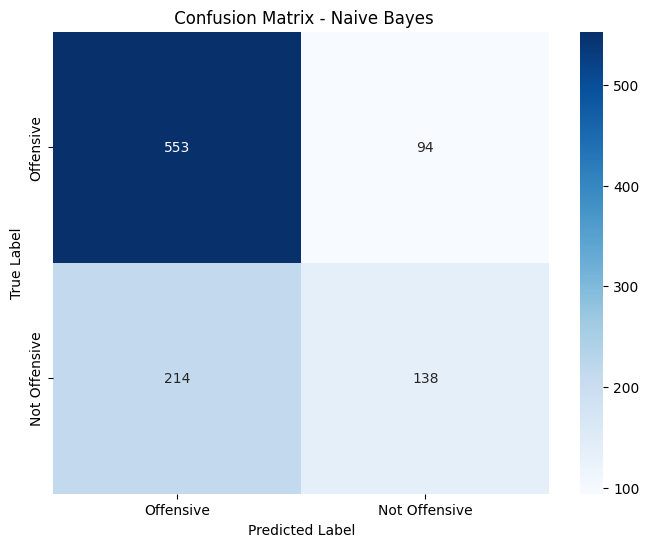

In [218]:
# Confusion matrix visualisation 
def plot_confusion_matrix(y_true, y_pred, title = ' Confusion Matrix - Naive Bayes'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    

# Show the confusion matrix
plot_confusion_matrix(y_dev, y_dev_pred)

# Ad hoc check  
To ensure that I didn't make any stupid mistake like turning the class names around

In [219]:
# Get predictions
y_dev_pred = tfidf_pipeline.predict(X_dev)

# Print some examples (showing the text, true label, and predicted label)
print("Example Predictions:")
print("-" * 100)  # Separator line
for text, true_label, pred_label in zip(X_dev[:10], y_dev[:10], y_dev_pred[:10]):
    print(f"Text: {text[:100]}...")  # Only show first 100 characters to keep output readable
    print(f"True label: {true_label}")
    print(f"Predicted label: {pred_label}")
    print(f"Correct prediction: {true_label == pred_label}")
    print("-" * 100)  # Separator line

# Also print some statistics
print("\nConfusion Matrix:")
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_dev, y_dev_pred))

Example Predictions:
----------------------------------------------------------------------------------------------------
Text: @USER He is not a troll he is simply dumb but I’m enjoying it I love tweeter for this 🤣🤣🤣🤣🤣🤣🤣...
True label: 1
Predicted label: 0
Correct prediction: False
----------------------------------------------------------------------------------------------------
Text: @USER I understand Annie she is stuck in between ! I understand her !...
True label: 0
Predicted label: 0
Correct prediction: True
----------------------------------------------------------------------------------------------------
Text: @USER @USER Hillary was blaming women not too long ago.  Better hope the Uneducated" don't show up t...
True label: 1
Predicted label: 0
Correct prediction: False
----------------------------------------------------------------------------------------------------
Text: @USER @USER I support Jahs blessings on his hussle ....he is d bomb...
True label: 1
Predicted label: